# Synthetic Data Generation by Megatron GPT

Big data, new algorithms and fast computers are the 3 main factors that make the modern AI revolution possible. Data poses a big challenge for enterprises for various reasons: difficulty  of data labeling, strong data governance, limited data availability etc. Synthetic data generation is proposed as a solution to the data problem as it directly addresses the data challenges. Two popular generative models like  Variational Auto-Encoder [VAE](https://en.wikipedia.org/wiki/Variational_autoencoder) and Generative Adversarial Network [GAN](https://en.wikipedia.org/wiki/Generative_adversarial_network) models have achieved some success in the past. However, a good generative model should generate the data following the same distribution as the training data. There are some known flaws with the VAE and GAN models for synthetic data generation. Most prominently, the [mode collapse problem](https://developers.google.com/machine-learning/gan/problems) in the GAN model causes the generated data to miss some modes in the training data distribution. While the VAE has the difficulty of generating sharp data points due to the non-autoregressive loss.

Recently, [Transformer models](https://arxiv.org/abs/1706.03762) achieved huge success in the natural language processing domain.  The self-attention encoding and decoding architecture of the transformer model is proven to be accurate in modeling the data distribution and scalable to large datasets. [OpenAI’s GPT3](https://openai.com/blog/gpt-3-apps/) uses the decoder part of the transformer model and has 175B parameters. It has been widely used across varying categories and industries, from productivity and education to creativity and games. GPT3 turns out to be a superior generative model. In this tutorial, we are interested in exploring the ideas of applying the GPT model for synthetic data generation. 

Unlike typical neural networks, GPT models are usually large in size. It is challenging to fit a large GPT model into a single GPU. Luckily, [NeMo Megatron](https://github.com/NVIDIA/NeMo) is an open source tool that is capable of efficiently training very large (hundreds of billions of parameters) language models with both model and data parallelism.  It is easy to use too. In the following sections, we will show how to train a GPT model step by step to generate synthetic credit card data.


### Get the Credit Card Transaction Data 

The synthetic credit card transaction dataset is provided at [IBM TabFormer Github repo](https://github.com/IBM/TabFormer). Go ahead to download it at this [direct link](https://ibm.box.com/v/tabformer-data).
 

In [ ]:
!wget https://public.boxcloud.com/d/1/b1!d9uc651aaxpo06Wit6Vq7jzxZXCw6oj-Vv0_bvD8Q6CMH3a13XoAjqoIBxGIVrVtDGOSfdxu0Z5VK4OG81TLh_hmH514MohzeK4-yngCDoujpFFXuNEGj9bPE1yjcyHnG9xU0Xry8BFvujoSwf9xDIBcZQlrsbkFrmA-6dkBuXiee3h6lHByl_DYsXer7XWh4t2jzSdPP0SRHFkOrf5FZ26RyjEccQA81nMWQsOtZ8X2Y3NGzzoRsGXNOnQyqf1-gVxfaux8LCo78PpHD667hsGHAUE_fMKIpjPn6hBmEo0-ODkjo2T9_uu6TDmMe1NcJ0uCwNunvlS1VEQypy9ErZwRZg32JTzsX20Ni2q_DgLNNzvZBWywfDpZu7pXyF-oXlp8IiZa1bUO2MViTfmReoT-dr0lta-WZE0FOur8wT7WGAwZnWKtKwHAaX4dFuEWdOkP8vYJOK6hb9RNKcC8cJPbAuxSddNtGI_Nw5U1oF89Z9XS3JLZCZ5IIIPx71eWkh-PA-GEztisFPIim9B5NqjATVDbFI5mX7u61h1UQqRxCLpmQkgCBPSOpAqDIBTVeDOT9N6HEAL8ssARW0K5SHPi6BZP08zcIwuso2JFFzbIq-0PN_3IUDO5wXjPb90axb82TtLgqdB3uQrK_00HWPo6AlvqlvIj8GhlEFbgrgmoNDMHDoxWIvAKMCNiXY-N1C22xUwbKMhUSG8jo4SimJCg76yVe5At3PF4T7IkOrGc3xjOjrRpF-9V3Astq52MH2LANkfha0mI0KNzMIS8rQ07Y2yKeFEl-4Kr8GIRdwWScBiiDncpkEeYyfX8a8meZ_F2IY-qv-lasN55O-LO1xwHt3gUGkSQoBsILBBAbkEt0N6TQh8xfVKhqmEvpYpTnMWk0nmDE7rbxfsGxHUTPzyMD0B_WlcVjaAsfZA7Htp2RBrR5W-gPlgBqqP-L4m-rq9LqwFPuTxB9htNvzS6TDO8J8Eqk3ueqvFM4dgLW9u62ndGFoNpfk6FGv8n89PsaN0wCVVmTB6TLjSQk0B6PkPc6A3HgPmG4EQEUpSy9P_fkiRlTn9-YjqW8m2iMkE9wcKZ9zDm--Q9QpxzHiZ-HED1dYTOCyBa0FfrNtC7Ms1Y7cR4HvxU0Ig5szkD5aJ7T4ARz2hZPhGkwJABKm0vv7yr_QlRpwXVo6jRiEEg3Pvrq4hkcAZ-dLXT77KUhU-41_JaZlYlUayBh4Dz5aTkQavmvuJ0keYRJFsw-QXHDZn3wqc747g2PNmbh0ZGn0BAbROdn0AfqzoAq5qreYC6q1OJOsSsDY9vkhw9CvIhIiEmJ1k./download -O data_file.tgz
!tar xfvz data_file.tgz

### Train Megatron GPT
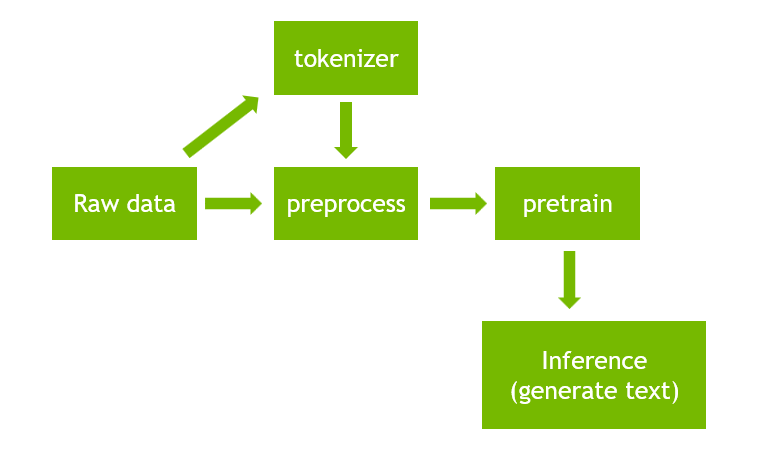

As shown in the figure above, to efficiently tokenize the text, we train a tokenizer for the provided training data.  As NeMo Megatron only cares about sequences of tokens, a preprocess step is used to convert the raw text data into sequences of token index. It results in one binary file and an index file.  The next step is the most time consuming pre-training step in which sequences of tokens are fed into the NeMo Megatron GPT to predict the next tokens. The prediction error is used as the loss to train the GPT weights. After training the GPT model, it can be put into an inference mode to generate synthetic data following the same distribution as the training dataset. 

### Convert the CSV File to JSON

First let's import the necessary Python libraries for the tutorial.

In [ ]:
import pandas as pd
from nemo.collections.common.tokenizers.column_coder import ColumnCodes
from omegaconf import OmegaConf
import pickle
from pandas.api.types import is_string_dtype
from nemo.collections.common.tokenizers.tabular_tokenizer import TabularTokenizer
import json
import wget

In [ ]:
BRANCH = 'main'
DATA_PATH='.'
TRANSACTIONS=DATA_PATH+'/card_transaction.v1.csv'
#CHECKPOINTS='/chk_points'
CHECKPOINTS=DATA_PATH+'/checkpoints'
CC_OUTPUT_P=DATA_PATH+'/credit_card_coder.pickle'
CC_OUTPUT_J=DATA_PATH+'/credit_card.jn'

In [ ]:
print (TRANSACTIONS, CHECKPOINTS, CC_OUTPUT_P, CC_OUTPUT_J)

After decompressing the tar file,  we load the dataset into pandas dataframe and examine the top few rows.

In [ ]:
df = pd.read_csv(TRANSACTIONS)
df.head()

In the following preprocessing step, We fix the `Amount` column that is not a number, convert the `Time` into `hour` and `minutes` and replace the `,` character with space so we can use `,` as delimiter.

In [ ]:
# remove the dollar string and convert amount to float
df['Amount'] = df['Amount'].str.replace('$', '').astype('float')
# fix the zip column
df['Zip'] = pd.array([None if pd.isna(x) else int(x) for x in df['Zip']])

# parse the time into minute and second
df['Hour'] = df['Time'].str[0:2]
df['Minute'] = df['Time'].str[-2:]
# remove the 'Time' Column once it is parsed
del df['Time']
# all the columns used for later processing 
all_columns = ['User', 'Year', 'Month', 'Day', 'Hour', 'Minute', 'Card', 'Amount', 'Use Chip',
           'Merchant Name', 'Merchant City', 'Merchant State', 'Zip', 'MCC',
           'Errors?', 'Is Fraud?']
# these are the columns used to train the model
columns = ['Year', 'Month', 'Day', 'Hour', 'Minute', 'Card', 'Amount', 'Use Chip',
           'Merchant Name', 'Merchant City', 'Merchant State', 'Zip', 'MCC',
           'Errors?', 'Is Fraud?']

float_columns = ['Amount']
category_columns = ['Year', 'Month', 'Day', 'Hour', 'Minute', 'Card', 'Use Chip',
                    'Merchant Name', 'Merchant City', 'Merchant State', 'MCC',
                    'Errors?', 'Is Fraud?']
integer_columns = ['Zip']

for col in category_columns:
    if is_string_dtype(df[col].dtype):
        df[col] = df[col].str.replace(',', ' ')

# after preprocessing
df = df[all_columns]
df.head()

There are 24M records with 12 fields. We need to convert the structured tabular data into a format that Megatron GPT can consume. The Megatron GPT uses training data in a loose json format, with one json containing a text sample per line. For example:
```json
{"text": "The quick brown fox"}
{"text": "jumps over the lazy dog"}
```
We can concat each fields of the transactions together like:
```json
{"text": "0,0,2002,9,1,06:21,$134.09,Swipe Transaction,3527213246127876953,La Verne,CA,91750.0,5300,NaN,No\n0,0,2002,9,1,06:42,$38.48,Swipe,Transaction,-727612092139916043,Monterey Park,CA,91754.0,5411,NaN,No..."}
...
```
In this way, the tabular data is converted into NLP text corpus. It is natural to select the generic GPT BPE tokenizer to convert the text into tokens. However, there are a few problems of using this approach. When GPT BPE tokenizer splits the text into tokens, the number of tokens are usually not fixed for the same column at different rows, because the number is determined by the occurrence frequencies of the individual sub-tokens. This means the structure information is lost if we use the NLP tokenizer. Another problem with the NLP tokenizer is the long string consists of a large number of tokens, which is wasteful considering the Megatron GPT has limited capacity of modeling the sequences of tokens. For example the "Mechant Name" "3527213246127876953" need at least 7 tokens to code it ([35][27][213][246][127][876][953]). 

As shown in the [TabFormer paper](https://arxiv.org/abs/2011.01843), a good solution is to build a specialized tokenizer for the tabular data that considers the table structural information. The TabFormer uses a single token for each of the columns which can cause either accuracy loss if the number of tokens is small for the column, or weak generalization if the number of tokens is too large. We improve it by using multiple tokens to code the columns. For example, the floating number "134.09" can be tokenized into multiple integers.

The following code trains a special encoder/decoder used in the tokenizer. It uses FloatCode for the "Amount" column, and categorical code for the rest of the columns. The trained coder and decoder are saved into a file that can be loaded later. We choose to use 3 tokens to encode the floating numbers in this example.

In [ ]:

tab_structure = []
for c in columns:
    if c in float_columns:
        item = {
            "name": c,
            "code_type": "float",
            "args": {
                "code_len": 3,  # number of tokens used to code the column
                "base": 32,   # the positional base number. ie. it uses 32 tokens for one digit
                "fillall": True, # whether to use full base number for each token or derive it from the data.
                "hasnan": False, # can it handles nan or not
                "transform": "yeo-johnson" # can be ['yeo-johnson', 'quantile', 'robust'], check https://scikit-learn.org/stable/modules/classes.html#module-sklearn.preprocessing 
            }
        }
    elif c in integer_columns:
        item = {
            "name": c,
            "code_type": "int",
            "args": {
                "code_len": 3,  # number of tokens used to code the column
                "base": 47,   # the positional base number. ie. it uses 32 tokens for one digit
                "fillall": True, # whether to use full base number for each token or derive it from the data.
                "hasnan": True, # can it handles nan or not
            }
        }
    else:
        item = {
            "name": c,
            "code_type": "category",
        }
    tab_structure.append(item)
print(OmegaConf.to_yaml(tab_structure))
print(columns)

example_arrays = {}
for col in tab_structure:
    col_name = col['name']
    if col_name in category_columns:
        example_arrays[col_name] = [i.strip() for i in df[col_name].astype(str).unique()]
    else:
        example_arrays[col_name] = df[col_name].dropna().unique()
cc = ColumnCodes.get_column_codes(tab_structure, example_arrays)
print('each row uses', sum(cc.sizes)+ 1, 'tokens')
with open(CC_OUTPUT_P, 'wb') as handle:
    pickle.dump(cc, handle)


Let's give it a try to play with encoder and decoder for "Amount" and "Merchant City" columns

In [ ]:
float_str = '134.09'
token_ids = cc.encode('Amount', float_str)
print('token ids for {} is {}'.format(float_str, token_ids))
amt_str = cc.decode('Amount', token_ids)
print('recovered Amt for {} is {}'.format(float_str, amt_str))

city_str = 'Monterey Park'
token_ids = cc.encode('Merchant City', city_str)
print('token ids for {} is {}'.format(city_str, token_ids))
amt_str = cc.decode('Merchant City', token_ids)
print('recovered City for {} is {}'.format(city_str, amt_str))

Using 3 tokens for the float column "Amount", this is a tiny loss of accuracy. If better accuracy is needed, more tokens can be used to train the tokenizer. For the categorical column "Merchant City", the string "Monterey Park" only needs one token to encode it. Once we have the encoder and decoder ready, the tokenizer is easy to implement. We can consider the tabular data structure information to encode each of the columns. The decoding simply counts the number of tokens to infer the tabular structure since the number of the tokens are fixed for each of the columns.

There is one more thing that we need to take special care of before generating the loose json file for Megatron. `<|endoftext|>` is a special token that NeMo Megatron recognizes to indicate the beginning and end of the document. The attention mask will stop at the boundary of `<|endoftext|>` token so no attention can be applied across it. To model the temporal information in the time series, we want to make sure the `<|endoftext|>` is added between the continuous sections. For example, in this credit card dataset, there are 2000 users. Each user's transactions are one long time series sequence. We split the long time series into smaller overlapping pieces with some strike number. The `<|endoftext|>` is only added at the end of the long sequences but not in between. In this way, NeMo Megatron applies attention to learn the temporal correlation in the transactions for the user but not across users. 

We have provided the Python code to convert the CSV file into the loose json format.

In [ ]:
import json
import functools
from multiprocessing import Pool

delimiter = ','
eod_str = '<|endoftext|>'
int_nan = '<NA>'


def get_docs_from_df(one_group):
    user_df = one_group[1]
    total = []
    # sort the rows by time, so the model can learn temporal info
    sub_df = user_df.sort_values(['Year', 'Month', 'Day', 'Hour', 'Minute'])[columns]
    start_rows = range(0, doc_augements)
    full_msgs = []
    for start in start_rows:
        full_msgs = []
        doc_df = sub_df.iloc[start:]
        count = 0
        df_size = len(doc_df)       
        for row in doc_df.iterrows():
            count += 1
            items = row[1].values
            str_items = [str(items[i]).replace(int_nan, 'nan') for i in range(len(items))]
            if count == df_size:
                # append eod at the end of the doc
                full_msgs.append(delimiter.join(str_items)+eod_str)
            else:
                full_msgs.append(delimiter.join(str_items))
        # use end of line to seperate rows
        text = '\n'.join(full_msgs)
        text_doc = {'text': text}
        doc = json.dumps(text_doc)+'\n'
        total.append(doc)
    return total


def gen_one_doc(user_group, n_cores):
    udfs = list(user_group)
    pool = Pool(n_cores)
    docs = pool.map(get_docs_from_df, udfs)
    pool.close()
    pool.join()
    return functools.reduce(lambda a, b: a + b, docs)

# number of document augmentation
doc_augements = 2

user_group = df.groupby('User')

with open('credit_card.jn', 'w') as f:
    docs = gen_one_doc(user_group, 30)
    for doc in docs:
        f.write(doc)

After running the above cell, it converts the CSV file to the loose json format that the Megatron can use.

Having the loose JSON file ready, we can test the customized Tabular Tokenizer.

In [ ]:
tokenizer = TabularTokenizer(CC_OUTPUT_P, delimiter=',')

with open('credit_card.jn', 'r') as f:
    for line in f:
        break

text = json.loads(line)['text']
r = tokenizer.text_to_tokens(text)
ids = tokenizer.tokens_to_ids(r)
tex = tokenizer.ids_to_tokens(ids)
decoded_text = tokenizer.ids_to_text(ids)
show_num_lines = 5
print('raw input text\n', '\n'.join(text.split('\n')[:show_num_lines]))
print('tokens\n', r[:show_num_lines*len(tokenizer.code_column.columns)])
print('token ids\n', ids[:show_num_lines*(sum(tokenizer.code_column.sizes)+1)])
print('decoded tokens\n', tex[:show_num_lines*(sum(tokenizer.code_column.sizes)+1)])
print('decoded text\n', '\n'.join(decoded_text.split('\n')[:show_num_lines]))

The TabularTokenizer understands the Table structure so it can convert back and forth between the tabular data text and the token ids.


### Model configuration

The `model_config.sh` file defines the model architecture and file paths. Please edit it to fits your computation environment.

```bash
# Runs the "600M" parameter model
GPUS_PER_NODE=4
# Change for multinode config
MASTER_ADDR=localhost
MASTER_PORT=6000
NNODES=1
NODE_RANK=0
WORLD_SIZE=$(($GPUS_PER_NODE*$NNODES))

DISTRIBUTED_ARGS="--nproc_per_node $GPUS_PER_NODE --nnodes $NNODES --node_rank $NODE_RANK --master_addr $MASTER_ADDR --master_port $MASTER_PORT"


OUTPUT_PAHT=checkpoints
PROJECT_NAME=creditcard
INPUT_FILE=credit_card.jn
DATA_PATH=${PROJECT_NAME}_text_document
CHECKPOINT_PATH=${OUTPUT_PAHT}/gpt_${PROJECT_NAME}
LOADPATH=${OUTPUT_PAHT}/gpt_${PROJECT_NAME}
TB_PATH=${OUTPUT_PAHT}/checkpoints/tb

TENSOR_MP_SIZE=1
PIPELINE_MP_SIZE=1

#model archi
NUM_LAYERS=48
HIDDEN_SIZE=1024
NUM_HEADS=16
SEQ_LEN=2048
MAX_POS_EMD=2048


VOCAB_FILE=credit_card_coder.pickle
TOKENIZER=TabularTokenizer
```

### Preprocess

The loose json above is processed into a binary format for training. To convert the json into mmap, cached index file use preprocess_data.py. 

The `preprocess.sh` script to prepare data for GPT training:
```bash
#!/bin/bash
source ./model_config.sh

python tools/preprocess_data.py --input=$INPUT_FILE \
                                --output-prefix=$PROJECT_NAME \
                                --vocab=$VOCAB_FILE \
                                --dataset-impl=mmap \
                                        --tokenizer-type=$TOKENIZER \
                                --workers=40

```
It uses `40` workers to do the preprocess step in parallel. Please adjust it for your enviroment.  

In [ ]:
wget.download(f'https://raw.githubusercontent.com/NVIDIA/NeMo/{BRANCH}/scripts/nlp_language_modeling/preprocess_data_for_megatron.py')

In [ ]:
!python preprocess_data_for_megatron.py \
    --input={CC_OUTPUT_J} \
    --json-keys=text \
    --tokenizer-library=tabular \
    --vocab-file={CC_OUTPUT_P} \
    --tokenizer-type=Tabular \
    --output-prefix=tabular_data \
    --delimiter=, \
    --workers=30


After running the script, two new files are generated in the current directory: `creditcard_text_document.bin` and `creditcard_text_document.idx`. The `bin` file is the mmap binary file and the `idx` is the cached index file. They will be used for the following pre-training step.

In [ ]:
!ls $DATA_PATH/tabular*.*

In [ ]:
wget.download(f'https://raw.githubusercontent.com/NVIDIA/NeMo/{BRANCH}/examples/nlp/language_modeling/megatron_gpt_pretraining.py')

In [ ]:
    !python megatron_gpt_pretraining.py \
                trainer.devices=1 \
                trainer.accelerator=gpu \
                trainer.log_every_n_steps=100 \
                trainer.val_check_interval=500 \
                trainer.accumulate_grad_batches=1 \
                trainer.max_steps=10000 \
                trainer.precision=16 \
                trainer.gradient_clip_val=1.0 \
                exp_manager.exp_dir=gpt_creditcard_results \
                model.tensor_model_parallel_size=1 \
                model.optim.name=fused_adam \
                model.optim.lr=2e-4 \
                model.optim.sched.warmup_steps=2 \
                model.optim.sched.constant_steps=2 \
                model.optim.sched.min_lr=8e-5 \
                model.max_position_embeddings=1024 \
                model.encoder_seq_length=1024 \
                model.data.seq_length=1024 \
                model.tokenizer.type=Tabular \
                model.tokenizer.library=tabular \
                model.tokenizer.vocab_file={CC_OUTPUT_P} \
                model.tokenizer.delimiter=\',\' \
                model.data.eod_mask_loss=True \
                model.data.splits_string=\'3800,200,0\' \
                model.num_layers=4 \
                model.hidden_size=1024 \
                model.num_attention_heads=16 \
                model.activations_checkpoint_method='block' \
                model.activations_checkpoint_num_layers=1 \
                model.data.data_prefix=[tabular_data_text_document]

### Pretrain

We are ready to pretrain the GPT model. As large models can be quite difficult to train due to memory constraints, Megatron makes it possible by using both Tensor model parallel and Pipeline model parallelism that enables training transformer models with billions of parameters. Tensor model parallelism and pipeline model parallelism are orthogonal to each other. The following figure shows how to divide the large model horizontally (intra-layer) and vertically (across layers) by tensor model parallelism and pipeline model parallelism.
![image.png](attachment:image.png)

On top of the model parallelism, we can apply the popular data parallelism to the training to fully utilize all the GPUs in the cluster. In this [paper](https://arxiv.org/pdf/2104.04473.pdf), it provides a few tips about how to setup the model parallelism and data parallelism optimally:

1. When considering different forms of model parallelism, tensor model parallelism should generally be used up to degree 𝑔 when using 𝑔-GPU servers, and then pipeline model parallelism can be used to scale up to larger models across server.
2. When using data and model parallelism, a total model-parallel size of 𝑀 = 𝑡 · 𝑝 should be used so that the model’s parameters and intermediate metadata fit in GPU memory; data parallelism can be used to scale up training to more GPUs.
3. The optimal microbatch size 𝑏 depends on the throughput and memory footprint characteristics of the model, as well as the pipeline depth 𝑝, data-parallel size 𝑑, and batch size 𝐵.

In our experiment, we only concern with training a model that fits into a single GPU. we set the tensor model parallel and pipeline model parallelism parameter to 1. In our system, we have 4 GPUs. Here is the script we used for the pretraining task.

```bash
#! /bin/bash
source ./model_config.sh

python -m torch.distributed.launch $DISTRIBUTED_ARGS \
       pretrain_gpt.py \
       --num-layers $NUM_LAYERS \
       --hidden-size $HIDDEN_SIZE \
       --num-attention-heads $NUM_HEADS \
       --micro-batch-size 4 \
       --global-batch-size 32 \
       --seq-length $SEQ_LEN \
       --max-position-embeddings $MAX_POS_EMD \
       --train-iters 500000 \
       --lr-decay-iters 320000 \
       --tensorboard-dir $TB_PATH \
       --save $CHECKPOINT_PATH \
       --data-path $DATA_PATH \
       --data-impl mmap \
       --split 949,50,1 \
       --distributed-backend nccl \
       --tensor-model-parallel-size $TENSOR_MP_SIZE \
       --pipeline-model-parallel-size $PIPELINE_MP_SIZE \
       --distributed-backend nccl \
       --lr 0.00015 \
       --lr-decay-style cosine \
       --min-lr 1.0e-5 \
       --weight-decay 1e-2 \
       --clip-grad 1.0 \
       --lr-warmup-fraction .01 \
       --checkpoint-activations \
       --log-interval 100 \
       --save-interval 5000 \
       --eval-interval 1000 \
       --eval-iters 10 \
       --load $LOADPATH \
       --vocab-file $VOCAB_FILE \
       --fp16
```
Run the pretraining task script below. Note, this is the most time consuming step. It takes days for the task to converge depending on the computation environment.

In [ ]:
!./pretrain_step.sh

The pretraining will save the checkpoint files periodically at the `CHECKPOINT_PATH`. `save-interval` in the script controls the frequency. We use 10k in this example. 
While the training job is running, we can use the `tensorboard` to monitor the training. Following are the training curves I have for training dataset and validation dataset.
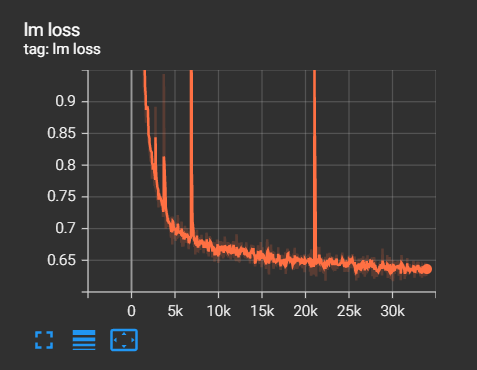
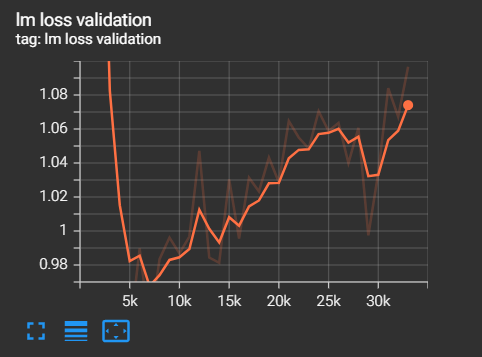
Clearly, the model is overfitted as shown in the validation curve. We can take the checkpoint file at the step 10k by modifying the `latest_checkpointed_iteration.txt` file to `10000` at the `CHECKPOINT_PATH`. Let's check the checkpoint files it generates

jj## Convert checkpoint to nemo file

In [ ]:
wget.download(f'https://raw.githubusercontent.com/NVIDIA/NeMo/{BRANCH}/examples/nlp/language_modeling/megatron_ckpt_to_nemo.py')

In [ ]:
!python -m torch.distributed.launch --nproc_per_node=1 megatron_ckpt_to_nemo.py \
    --checkpoint_folder=gpt_creditcard_results/megatron_gpt/checkpoints/ \
    --checkpoint_name=megatron_gpt--val_loss=1.17-step=10047-consumed_samples=80376.0-last.ckpt \
    --nemo_file_path=tabular.nemo \
    --tensor_model_parallel_size=1 \
    --pipeline_model_parallel_size=1 \
    --gpus_per_node=1 \
    --model_type=gpt

In [ ]:
!ls checkpoints/gpt_600m_credit_card


### Generate synthetic credit card transactions

We come to the last step of this workshop - generate synthetic credit card transactions!

First let's load the trained model weights, put the Megatron GPT in inference mode and start the text generation server. All of these can be done by running the `run_data_gen_server.sh` script. Open another Jupyter notebook, and run the following in a cell. 
```bash
!./run_data_gen_server.sh
```
The text generation server accepts REST API request to send the generated text in the response. Let's use the following Python code to generate some transactions.

In [ ]:
wget.download(f'https://raw.githubusercontent.com/NVIDIA/NeMo/{BRANCH}/examples/nlp/language_modeling/megatron_gpt_eval.py')

In [ ]:
!python megatron_gpt_eval.py \
    model_file=tabular.nemo

In [ ]:
import requests
import json
from coder.column_code import ColumnCodes
import pickle

with open('credit_card_coder.pickle', 'rb') as handle:
        cc: ColumnCodes = pickle.load(handle)

token_per_rows = sum(cc.sizes) + 1

batch_size = 16
port_num = 5000
num_of_rows = 30
headers = {"Content-Type": "application/json"}


def request_data(data):
    resp = requests.put('http://localhost:{}/generate'.format(port_num),
                        data=json.dumps(data), headers=headers)
    sentences = resp.json()['sentences']
    return sentences


# generate the inital transactions 
data = {
    "sentences": [""] * batch_size,
    "tokens_to_generate": num_of_rows * token_per_rows,
    "temperate": 1.0,
    "add_BOS": True
}

sentences = request_data(data)

for i in range(batch_size):
    s = sentences[i]
    print(s)

The above code only generate `num_of_rows` of transactions starting from the beginning. If longer sequence is needed, we can run the inference conditioned on the past transactions in a sliding window fashion. For example, first it generates [A, B, C, D, E] transactions conditioned on `<|endoftext|>` token. Then, it conditions on [D, E] and generates [D, E, F, G, H]. Once the long sequence comes to the end indicated by `<|endoftext|>`, it will keep generating new transactions for a different user. For example, after generating [X, Y, Z, <|endoftext|>] in the last run, it will generate [Z, <|endoftext|>, A', B', C'] in the next time, where A', B', C' are transactions for a different user and they are not depending on the other users transaction Z.  

The following code implements the idea above and can be used to generate massive number of transactions in long sequences:

In [ ]:
import requests
import json
from coder.column_code import ColumnCodes
import pickle

with open('credit_card_coder.pickle', 'rb') as handle:
        cc: ColumnCodes = pickle.load(handle)

# batch_size = 32
batch_size = 16
num_of_rows = 50
token_per_rows = sum(cc.sizes) + 1
history_rows = 40
num_of_blocks = 3000

port_num = 5000
headers = {"Content-Type": "application/json"}

prefix_name = 'synthetic'
files = []


for i in range(batch_size):
    files.append(open("{}_{}.txt".format(prefix_name, i), 'w'))


def request_data(data):
    resp = requests.put('http://localhost:{}/generate'.format(port_num),
                        data=json.dumps(data), headers=headers)
    sentences = resp.json()['sentences']
    return sentences


def get_condition_text(sentences, history_rows):
    condition_text = ['\n'.join([ss for ss in s.split(
        '\n')[-(history_rows+1):]]) for s in sentences]
    return condition_text


def get_extra_text(sentences, history_rows):
    extra_text = ['\n'.join([ss for ss in s.split(
        '\n')[history_rows:]]) for s in sentences]
    return extra_text

# generate the inital transactions 
data = {
    "sentences": [""] * batch_size,
    "tokens_to_generate": num_of_rows * token_per_rows,
    "temperate": 1.0,
    "add_BOS": True
}

sentences = request_data(data)

for i in range(batch_size):
    s = sentences[i]
    files[i].write(s.replace('<|endoftext|>', '\n'))

# generate the transactions conditioned on the previous ones
for block in range(num_of_blocks):
    print("block id: {}".format(block))
    condition_text = get_condition_text(sentences, history_rows)
    # print('conditional text')
    # for s in condition_text:
    #     print(s)

    data = {
        "sentences": condition_text,
        "tokens_to_generate": num_of_rows * token_per_rows,
        "temperate": 1.0,
        "add_BOS": False
    }

    sentences = request_data(data)

    # print('final ')
    # for s in sentences:
    #     print(s)

    extra_text = get_extra_text(sentences, history_rows)

    for i in range(batch_size):
        s = extra_text[i]
        files[i].write(s.replace('<|endoftext|>', '\n'))
        files[i].flush()


for i in range(batch_size):
    files[i].close()

That's it! In this workshop, you have learned how to train a Megatron GPT model to generate synthetic data. Go ahead and apply it for your own data.